<img style="float: right;" src="meetup_logo.svg" width=200>

# Event Topic Modeling

<i>Topic modeling on event descriptions.</i>

Extracting latent topics in event descriptions to assign topic to each event. Will try using these topics to feed into models in place of the group_category, which proved not to be a very important feature (per random forest feature importance graph).

Source: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/


***

## 0. Import necessary libraries

In [1]:
import nltk
from nltk.corpus import stopwords

import re
import numpy as np
import pandas as pd
import pickle

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy

import pyLDAvis
import pyLDAvis.gensim 
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

## 1. Data Cleaning

In [2]:
df = pd.read_pickle('df_sepoct_events_groups_merged_cleaned.pickle')

In [3]:
df.head(1)

,event_created,event_description,event_duration,event_url,fee,group,event_headcount,how_to_find_us,event_id,maybe_rsvp_count,...,group_state,group_status,group_urlname,group_visibility,group_who,group_category,group_organizer_id,group_yrs_est,group_created_date,num_past_events
0,1535391367000,Join us in person or tune in online! Livestrea...,120.0,https://www.meetup.com/Build-with-Code-New-Yor...,0.0,"{'join_mode': 'open', 'created': 1484876702000...",0,Please come to second floor/ stream online at ...,254149786,0,...,NY,active,Build-with-Code-New-York,public,Engineers,tech,218119162,2.276969,01/20/2017 01:45:02,38


In [4]:
df.columns

Index(['event_created', 'event_description', 'event_duration', 'event_url',
       'fee', 'group', 'event_headcount', 'how_to_find_us', 'event_id',
       'maybe_rsvp_count', 'event_name', 'photo_url', 'event_rating',
       'rsvp_limit', 'event_status', 'event_time', 'event_updated',
       'utc_offset', 'event_visibility', 'waitlist_count', 'why',
       'yes_rsvp_count', 'group_is_open', 'group_id', 'has_how_to_find',
       'has_rsvp_limit', 'event_num_words', 'has_photo', 'venue_latlon',
       'time_datetime', 'time_m_d_y', 'day_of_week', 'event_hour',
       'event_hour_group', 'subway_distances', 'num_close_subways',
       'has_event_fee', 'created_to_event_days', 'group_created',
       'group_description', 'group_join_mode', 'group_lat', 'group_link',
       'localized_country_name', 'localized_location', 'group_lon',
       'num_members', 'group_name', 'group_state', 'group_status',
       'group_urlname', 'group_visibility', 'group_who', 'group_category',
       'group_org

We'll work with just a subset of the events data: event_name, event_description, group_name, group_category.

In [5]:
# create new dataframe with just the data we need
df_subset = df[['event_name','event_description', 'group_name', 'group_category']]
df_subset.head(1)

,event_name,event_description,group_name,group_category
0,"JavaScript The Easier Parts: Objects, Function...",Join us in person or tune in online! Livestrea...,Build with Code - New York City,tech


In [6]:
# put all of our 'documents' (i.e. each event_description) into a list to make our corpus
data = df_subset.event_description.values.tolist()

In [7]:
print(f'There are {len(data)} observations in the corpus.')

There are 25424 observations in the corpus.


Use regex to clean up event description. Specifically, remove urls and email addresses.

In [8]:
# remove urls starting with http or https
data = [re.sub('(http|https)\:\/\/[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(\/\S*)?', '', d) for d in data]

# further remove urls starting with www
data = [re.sub('(www)\.[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(\/\S*)?', '', d) for d in data] 

# remove emails
data = [re.sub('\S*@\S*\s?', '', d) for d in data]

# remove .com text
data = [re.sub('[a-zA-Z0-9]+(\.com)', '', d) for d in data] 

# remove time
data = [re.sub('([0-9]+\:+[0-9]*)', '', d) for d in data]

In [9]:
# view a cleaned event_description
data[10]

"Please tune into the stream here:  Do you want to build applications and learn to code in JavaScript? Perhaps you've attended JavaScript the Hard Parts and want to start building full applications. Or, perhaps you've been building applications for some time or working though fundamentals of functional and object oriented programming in JS and want to discover what it takes to become a full-stack software engineer In this free information session, members of the Codesmith team and community will answer questions on their experience at Codesmith and share advice on the journey to becoming a software engineer As part of an open QA we will discuss: • Why we teach JavaScript, Computer Science, React and Node • Why Codesmith emphasizes working on production code • What hiring support does Codesmith provide • How to get started and go under-the-hood with JavaScript • What is the experience of learning and building at Codesmith  Schedule - PM: Info Session - PM: QA ft. panel of current Codesm

There's still more to clean - will use ```simple_process()``` to remove punctuations and other characters that are not needed while tokenizing the text as well. Setting ```deacc=True``` to ensure punctuations are removed.

In [10]:
def sentence_to_words(sentences):
    for sen in sentences:
        yield(gensim.utils.simple_preprocess(str(sen), deacc=True))

data_words = list(sentence_to_words(data))

print(data_words[:1])

[['join', 'us', 'in', 'person', 'or', 'tune', 'in', 'online', 'livestream', 'get', 'started', 'now', 'on', 'challenges', 'related', 'to', 'these', 'topics', 'on', 'our', 'free', 'online', 'learning', 'platform', 'csx', 'during', 'this', 'workshop', 'we', 'will', 'cover', 'what', 'happens', 'when', 'our', 'code', 'runs', 'in', 'the', 'browser', 'closer', 'look', 'at', 'objects', 'reusing', 'our', 'logic', 'declaring', 'invoking', 'functions', 'these', 'concepts', 'are', 'the', 'foundation', 'of', 'all', 'web', 'development', 'we', 'will', 'cover', 'them', 'under', 'the', 'hood', 'so', 'you', 'can', 'confidently', 'use', 'them', 'as', 'you', 'work', 'on', 'harder', 'concepts', 'to', 'come', 'schedule', 'pm', 'meet', 'your', 'future', 'pair', 'programming', 'partner', 'pm', 'core', 'javascript', 'concept', 'for', 'the', 'challenge', 'and', 'introduction', 'to', 'the', 'secret', 'hack', 'for', 'learning', 'to', 'code', 'pair', 'programming', 'pm', 'pair', 'programming', 'bring', 'friend', 

How that we have cleaned tokens, we can put together a bigram model to see which two words occur together most frequently to gain a deeper understanding of the document's topics.

In [11]:
# building bigram model
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=50) # higher threshold fewer phrases.

# quicker way to get bigram
bigram_model = gensim.models.phrases.Phraser(bigram)

# bigram example
print(bigram_model[data_words[2000]])

['please', 'register', 'for', 'and', 'tune', 'into', 'the', 'stream', 'here', 'this', 'week', 'for', 'javascript', 'the', 'hard_parts', 'we', 'cover_callbacks', 'and', 'higher_order', 'functions', 'this', 'includes', 'how', 'to', 'handle', 'or', 'recreate', 'the', 'functions', 'map_reduce', 'foreach', 'this', 'is', 'concept', 'that', 'of', 'javascript_engineers', 'do', 'not', 'understand', 'but', 'are', 'at', 'the', 'core', 'of', 'every', 'single', 'successful_application', 'this', 'is', 'possible', 'because', 'we', 'll', 'understand', 'the', 'essence', 'of', 'these_tough', 'concepts', 'and', 'then', 'switch', 'into', 'pair_programming', 'through', 'the', 'challenges', 'to', 'cement', 'the', 'concepts', 'schedule', 'pm', 'meet', 'your', 'future', 'pair_programming', 'partner', 'pm', 'core_javascript', 'concept', 'for', 'the', 'challenge', 'and', 'introduction', 'to', 'the', 'secret_hack', 'for', 'learning', 'to', 'code', 'pair_programming', 'pm', 'pair_programming', 'sign', 'in', 'with

In [12]:
print(bigram_model[data_words[500]])

['purchase', 'online', 'celebrate', 'no', 'work', 'monday', 'at', 'our', 'annual_labor', 'day_eve', 'yacht_cruise', 'this', 'will', 'be', 'out', 'last', 'singles', 'yacht_cruise', 'of', 'the', 'year', 'so', 'don', 'miss', 'it', 'mix_mingle', 'drink', 'dance', 'the', 'night', 'away', 'with', 'multi', 'meetup', 'groups', 'while', 'enjoying', 'panoramic_view', 'of', 'nyc', 'skyline', 'on', 'foot', 'long', 'deck', 'private', 'yacht', 'what', 'included', 'light_appetizers', 'dj', 'ice_breakers', 'cash', 'bar', 'prizes', 'singles', 'we', 'already', 'have', 'members', 'prepaid', 'for', 'this', 'cruise', 'and', 'only', 'tickets', 'left', 'this', 'will', 'sell', 'out', 'quickly', 'so', 'get', 'your', 'tickets', 'today', 'the', 'boat', 'will', 'sail_rain', 'or', 'shine', 'the', 'boat', 'has', 'two', 'levels', 'the', 'main_level', 'is', 'air_conditioned', 'and', 'enclosed', 'and', 'there', 'is', 'an', 'outside_deck', 'on', 'the', 'second_level', 'boarding_starts', 'at', 'pm', 'the', 'boat', 'will

In [13]:
# make sure we have our stopwords
stop_words = stopwords.words('english')
stop_words.extend(['join', 'meet', 'event', 'attend', 'time', 'day', 'week', 'group','pm', 'am',
                  'nyc', 'new', 'york', 'rsvp', 'come', 'register', 'contact','welcome','member', 'session',
                  'schedule', 'get', 'meetup', 'st', 'rd', 'ave', 'th'])

In [14]:
len(list(set(stop_words)))

205

In [15]:
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

Before we move forward, will need to remove stopwords and lemmatize words before making bigrams.

In [16]:
# helper functions
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_model[doc] for doc in texts]

def lemmatization(texts,allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

Try out the functions above.

In [17]:
# !python3 -m spacy download en

In [18]:
# Remove Stop Words
data_words_stopped = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_stopped)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams)

print(data_lemmatized[:1])

[['person', 'tune', 'online', 'livestream', 'start', 'challenges_relat', 'topic', 'free', 'online', 'learn', 'workshop', 'cover', 'happen', 'code', 'run', 'browser', 'close', 'look', 'objects_reus', 'logic_declar', 'invoking_function', 'concept', 'foundation', 'web_development', 'cover', 'hood', 'confidently_use', 'work', 'harder_concept', 'future', 'pair_programm', 'partner', 'core_javascript', 'concept', 'challenge', 'introduction', 'secret_hack', 'learn', 'code', 'pair_programm', 'pair_programming', 'bring', 'friend', 'build', 'pair', 'program', 'together', 'price', 'always', 'free', 'online', 'stream', 'livestream']]


In order to work with LDA topic model, we'll need to create a dictionary and our corpus. The results of the corpus will be a tuple with ```(word_id, word_frequency)```.

In [19]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

# to get the actual word for a given word_id: id2word[word_id]
print(id2word[0])

# for a fuller picture of the corpus
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2), (8, 2), (9, 1), (10, 1), (11, 2), (12, 1), (13, 2), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 2), (22, 2), (23, 1), (24, 1), (25, 1), (26, 3), (27, 1), (28, 2), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1)]]
always


[[('always', 1),
  ('bring', 1),
  ('browser', 1),
  ('build', 1),
  ('challenge', 1),
  ('challenges_relat', 1),
  ('close', 1),
  ('code', 2),
  ('concept', 2),
  ('confidently_use', 1),
  ('core_javascript', 1),
  ('cover', 2),
  ('foundation', 1),
  ('free', 2),
  ('friend', 1),
  ('future', 1),
  ('happen', 1),
  ('harder_concept', 1),
  ('hood', 1),
  ('introduction', 1),
  ('invoking_function', 1),
  ('learn', 2),
  ('livestream', 2),
  ('logic_declar', 1),
  ('look', 1),
  ('objects_reus', 1),
  ('online', 3),
  ('pair', 1),
  ('pair_programm', 2),
  ('pair_programming', 1),
  ('partner', 1),
  ('person', 1),
  ('price', 1),
  ('program', 1),
  ('run', 1),
  ('secret_hack', 1),
  ('start', 1),
  ('stream', 1),
  ('together', 1),
  ('topic', 1),
  ('tune', 1),
  ('web_development', 1),
  ('work', 1),
  ('workshop', 1)]]

Build the LDA Model. Based on the coherence score test, 8 topics generated the highest coherence score so we'll use that as our final LDA model.

In [20]:
lda_model_8 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=5,
                                           alpha='auto',
                                           per_word_topics=True)

In [21]:
# Print keywords in each topic
print(lda_model_8.print_topics())
doc_lda_8 = lda_model_8[corpus]

[(0, '0.032*"hike" + 0.030*"trip" + 0.020*"hiking" + 0.019*"columbia_university" + 0.018*"trail" + 0.015*"translation" + 0.014*"lunch" + 0.012*"drive" + 0.011*"masked" + 0.011*"mile"'), (1, '0.042*"dance" + 0.032*"free" + 0.027*"party" + 0.016*"mask" + 0.016*"tango" + 0.014*"drink" + 0.014*"city" + 0.012*"dress" + 0.012*"friend" + 0.011*"floor"'), (2, '0.012*"energy" + 0.011*"life" + 0.010*"meditation" + 0.010*"year" + 0.008*"body" + 0.008*"experience" + 0.008*"healing" + 0.007*"work" + 0.006*"world" + 0.006*"create"'), (3, '0.011*"rain" + 0.010*"park" + 0.010*"take" + 0.008*"mask" + 0.008*"include" + 0.008*"street" + 0.008*"go" + 0.007*"site" + 0.007*"see" + 0.007*"enjoy"'), (4, '0.020*"people" + 0.017*"pay" + 0.015*"great" + 0.015*"fun" + 0.014*"member" + 0.013*"attend" + 0.012*"ticket" + 0.011*"must" + 0.011*"purchase" + 0.011*"age"'), (5, '0.036*"class" + 0.015*"practice" + 0.013*"learn" + 0.013*"free" + 0.011*"level" + 0.008*"october" + 0.007*"mask" + 0.007*"student" + 0.007*"brin

How is the model doing? Check the model perplexity and coherence score.

In [22]:
# Compute Perplexity
print('\nPerplexity: ', lda_model_8.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score (higher the better)
coherence_model_lda = CoherenceModel(model=lda_model_8, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.292147222081812

Coherence Score:  0.48812218994188905


Visualize the topics-keywords. 

Each bubble on left represents a topic. Larger the buble, the more prevalent that topic is.

Good topics will have larger, non-overlapping bubbles scattered across the chart instead of clustering in a quadrant. Overlapping smaller bubbles in a specific region will occur if there are too many topics.

In [23]:
# Visualize the topics
pyLDAvis.enable_notebook()
visual = pyLDAvis.gensim.prepare(lda_model_8, corpus, id2word)
visual

/Users/gracejeong/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.144418  0.125431       1        1  31.613117
5     -0.232441 -0.063189       2        1  25.051815
3     -0.131124  0.029742       3        1  15.332331
2     -0.114912 -0.317078       4        1  12.603213
1     -0.040700  0.188782       5        1   5.652042
6      0.117482  0.205228       6        1   5.229157
7      0.283564 -0.056531       7        1   2.585008
0      0.262549 -0.112384       8        1   1.933316, topic_info=      Category          Freq            Term         Total  loglift  logprob
term                                                                        
419    Default  20614.000000           class  20614.000000  30.0000  30.0000
1954   Default   6995.000000            game   6995.000000  29.0000  29.0000
409    Default  14195.000000          ticket  14195.000000  28.0000  28.0000
146    Default  10962.000000            must  10962.000000  27.0000  27.0000
13     Default  14685.000000            free  14685.000000  26.0000  26.0000
1167   Default   9922.000000        purchase   9922.000000  25.0000  25.0000
1342   Default   7084.000000           dance   7084.000000  24.0000  24.0000
886    Default   4223.000000            play   4223.000000  23.0000  23.0000
1619   Default   6836.000000           party   6836.000000  22.0000  22.0000
5219   Default   3769.000000          player   3769.000000  21.0000  21.0000
388    Default  12176.000000             pay  12176.000000  20.0000  20.0000
104    Default   5878.000000            team   5878.000000  19.0000  19.0000
187    Default  11887.000000              go  11887.000000  18.0000  18.0000
2692   Default   8417.000000        practice   8417.000000  17.0000  17.0000
14     Default   9680.000000          friend   9680.000000  16.0000  16.0000
1916   Default   7606.000000           alone   7606.000000  15.0000  15.0000
2235   Default   8495.000000             age   8495.000000  14.0000  14.0000
78     Default   7997.000000           drink   7997.000000  13.0000  13.0000
533    Default   6131.000000           enjoy   6131.000000  12.0000  12.0000
194    Default   9828.000000          member   9828.000000  11.0000  11.0000
237    Default   9435.000000            mask   9435.000000  10.0000  10.0000
230    Default  11064.000000           great  11064.000000   9.0000   9.0000
173    Default   9075.000000          attend   9075.000000   8.0000   8.0000
767    Default  17274.000000          people  17274.000000   7.0000   7.0000
1156   Default   7775.000000           night   7775.000000   6.0000   6.0000
142    Default   7302.000000           level   7302.000000   5.0000   5.0000
1053   Default   5746.000000          masked   5746.000000   4.0000   4.0000
2967   Default   5239.000000           dress   5239.000000   3.0000   3.0000
1829   Default   5242.000000          street   5242.000000   2.0000   2.0000
545    Default  11752.000000             fun  11752.000000   1.0000   1.0000
...        ...           ...             ...           ...      ...      ...
1021    Topic8    223.929718       elevation    225.308304   3.9398  -5.2717
5469    Topic8    222.360275          winery    223.732422   3.9398  -5.2788
3835    Topic8    213.793060  processing_fee    215.171753   3.9395  -5.3181
1601    Topic8    211.820633   bear_mountain    213.196228   3.9395  -5.3273
6600    Topic8    208.846649             sky    210.218628   3.9394  -5.3415
3896    Topic8    205.444611            moon    206.819916   3.9393  -5.3579
14672   Topic8    199.144272         hayride    200.521317   3.9390  -5.3890
9894    Topic8    195.143600             row    196.545883   3.9388  -5.4093
8448    Topic8    201.224319           robot    202.677399   3.9387  -5.3787
12289   Topic8    187.242172            thus    188.620728   3.9386  -5.4507
12827   Topic8    182.619263           pound    183.991699   3.9384  -5.4757
1277    Topic8    181.899460 

Find optimal number of topics

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=5):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics , 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=5,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

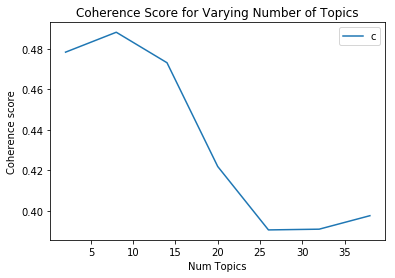

In [31]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.title('Coherence Score for Varying Number of Topics')
plt.show()

In [32]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4783
Num Topics = 8  has Coherence Value of 0.4881
Num Topics = 14  has Coherence Value of 0.4731
Num Topics = 20  has Coherence Value of 0.4219
Num Topics = 26  has Coherence Value of 0.3907
Num Topics = 32  has Coherence Value of 0.3911
Num Topics = 38  has Coherence Value of 0.3977


Assign topic with keywords to each document.

In [25]:
def format_topics_sentences(ldamodel=lda_model_8, corpus=corpus, texts=data):
    # Init output
    topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key =lambda x: (x[1]), reverse = True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                topics_df = topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    topics_df = pd.concat([topics_df, contents], axis=1)
    return(topics_df)



In [26]:
df_topic_keywords = format_topics_sentences(lda_model_8, corpus, data)

In [27]:
# Format
df_dominant_topic = df_topic_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(20)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,5.0,0.8443,"class, practice, learn, free, level, october, ...",Join us in person or tune in online! Livestrea...
1,1,5.0,0.8589,"class, practice, learn, free, level, october, ...",Get started now on challenges related to these...
2,2,5.0,0.8839,"class, practice, learn, free, level, october, ...",In this workshop we’ll get a clear sense of th...
3,3,5.0,0.8442,"class, practice, learn, free, level, october, ...",The number of opportunities for software engin...
4,4,5.0,0.8911,"class, practice, learn, free, level, october, ...",Please tune into the stream here: Do you want...
5,5,5.0,0.8442,"class, practice, learn, free, level, october, ...",Join us in person or tune in online! Livestrea...
6,6,5.0,0.8435,"class, practice, learn, free, level, october, ...",Please register for and tune into the stream h...
7,7,5.0,0.7862,"class, practice, learn, free, level, october, ...","Join us on Thursday, Sep 13, for a great serie..."
8,8,5.0,0.7189,"class, practice, learn, free, level, october, ...","Join us on Thursday, for a great series of lig..."
9,9,5.0,0.5681,"class, practice, learn, free, level, october, ...",In this online workshop (9am-3pm PST / 12-6pm ...


In [28]:
df_keywords_value_counts = pd.DataFrame(df_dominant_topic.Keywords.value_counts()).reset_index()
df_keywords_value_counts.columns = [['keywords', 'occurence']]

In [32]:
pd.set_option('display.max_colwidth', -1)

df_keywords_value_counts

,keywords,occurence
0,"class, practice, learn, free, level, october, mask, student, bring, business",9744
1,"people, pay, great, fun, member, attend, ticket, must, purchase, age",6518
2,"rain, park, take, mask, include, street, go, site, see, enjoy",3477
3,"energy, life, meditation, year, body, experience, healing, work, world, create",2621
4,"dance, free, party, mask, tango, drink, city, dress, friend, floor",1762
5,"ticket, parking, enjoy, purchase, street, mix_mingle, dance, available, casual, arrive",891
6,"game, play, player, movement, must, tennis, lose, team, drill, field",355
7,"hike, trip, hiking, columbia_university, trail, translation, lunch, drive, masked, mile",56


Most representative document for each topic.

In [33]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.5242,"hike, trip, hiking, columbia_university, trail, translation, lunch, drive, masked, mile","Marlin Fishing in Cuba at the Marina Hemingway Calle 248 Y 5Ta Av. Santa Fe Playa Havana, Cuba :: :: :; Held at Marina Hemingway, 9 miles west of Havana, the Hemingway International Billfishing Tournament hosts fishermen from around the world in pursuit of marlin and other large deep sea fish, including tuna and wahoo, using 50-pound fishing line. More info HERE and HERE. Repeats 2nd Saturday of every month. :: :: :: Alternate Trip: Deep Sea Fishing in Panama &lt;iframe width=""560"" height=""315"" src="" frameborder=""0"" allowfullscreen&gt;&lt;/iframe&gt;"
1,1.0,0.8564,"dance, free, party, mask, tango, drink, city, dress, friend, floor","Join us for the party at Monarch rooftop and indoor lounge this Saturday evening! Monarch is a beautiful rooftop lounge with both indoor and outdoor sections. There will be a live DJ and plenty of space to sit, chat, stand, and dance! Entry is free when the doorperson knows you’re with me, Rory. The place gets packed, so try to get in before midnight! We’ll be there starting at 11pm. Be sure to dress up (business casual, no sneakers, no sweatshirts/hoodies, no shorts for men, no large bags/backpacks). The doorpeople are very strict on these policies! There are heaters located outside for warmth. With views of the Empire State Building and Manhattan city lights, this is one of the must-see lounges in NYC. Hope to see you there! Cheers, Rory [masked]) How much: FREE when you tell the doorperson you’re with Rory Date: Every Saturday Time: 11pm - 4am Where: Monarch Rooftop Indoor Lounge 71 W 35th Street 18th Floor Dress code: Business Casual (absolutely no sneakers, no sweatshirts/hoodies, no shorts for men, no large bags) Subway: 1, 2, 3, B, D, F, N, Q, R, and Path Train to 34th Street"
2,2.0,0.7808,"energy, life, meditation, year, body, experience, healing, work, world, create","Bienvenidos al Canto del HU Comunitario! El Canto de HU es una cancion de amor a Dios, y un ejercicio espiritual basico que se practica para el crecimiento espiritual. Esta abierto a personas de todos los credos y religiones, y el equipo de ECKANKAR lo presenta como servicio comunitario a aquellas personas que desean explorar un poco mas en su camino hacia Dios. Al concluir, hay oportunidad de conversar y conmpartir un refrigerio ligerio con otras personas enfocadas en el crecimiento espiritual."
3,3.0,0.9157,"rain, park, take, mask, include, street, go, site, see, enjoy","6-7 miles; moderate pace on flat terrain. Finish between - PM. Walk along Narrows to Coney Island taking in beautiful views of the bay area along the Narrows. Walk from subway station to pathway along the Narrows to Surf and Stillwell Ave and end by Nathan’s in Coney Island. Subway (D, F, N, and Q) station at end of walk is across the street from Nathan’s. Bring lunch and water or purchase lunch at Caesar’s Bay Bazaar. Meet AM outside the last stop of R subway line, 95th Street and 4th Ave in Bayridge. Rain cancels. Must call or email to confirm that walk is on. Leader: Edward Leibowitz,[masked]; Email: [masked]; Cell phone[masked] only on day of walk after AM. Nonmembers of Shorewalkers and Outdoors Club: $3. Joint walk."
4,4.0,0.9720,"people, pay, great, fun, member, attend, ticket, must, purchase, age","*PAY ONLINE (Prepay Only Event) - Join us for THE OFFICE TRIVIA NIGHT! We had such a big response from our Meetup groups to the last one so we're doing it again! How it works:We will have 4-6 teams and approximately 5 rounds. Work with your teammates to get the most questions right. You are eligible to win some great prizes at the end of the event. Coming alone? No problem! Part of the fun is meeting new friends. We will put you on a team with other fans of The Office! Questions will range from easy to hard... that's what she said ;) Please note: There is a 1-drink minimum purchase at this venue. If you

In [31]:
sent_topics_sorteddf_mallet.to_csv('representative_topics_text.csv')

In [ ]:
df.columns

In [ ]:
df.yes_rsvp_count.describe()

In [ ]:
len(df)

In [ ]:
df_merged = pd.concat([df_dominant_topic, df], axis=1)

In [ ]:
df_merged.columns

In [ ]:
df_merged[df_merged['yes_rsvp_count']==0]

In [ ]:
df_merged_sorted = df_merged.sort_values(by = 'Topic_Perc_Contrib' )

In [ ]:
df_merged_sorted.drop_duplicates()